# Hack IMDb Rating
## Introduction

Welcome to the Movie Data Analysis Project! This notebook is designed to take you through a comprehensive journey of exploring, analyzing, and understanding the intricate world of movies. Our primary goal is to uncover the factors that influence a movie's success, focusing on aspects such as revenue generation and IMDB ratings.

This notebook is structured to guide you through each step of the process, from data loading and cleaning to in-depth analysis. So, let's dive in and explore the fascinating world of movies through the lens of data science!



## Research Questions

1. *What factors contribute to a movie's success, and how do they interplay?*
   - Language and its role in reaching a wider audience
   - Impact of film duration
   - The influence of release timing on ratings
   - How movie genres have evolved over time
   - The correlation between box office success and ratings
   - Geographical patterns in movie ratings 
   

2. *How does diversity and representation influence movie ratings?*
   - Gender diversity within film casts
   - The effect of ethnic diversity on a film's reception

3. *What impact do actors have on a film's rating?*
   - The role of actor types and their influence
   - Effects of actor collaborations on film ratings

4. *Does the portrayal of characters (protagonists) affect ratings?*

5. *Is there a link between real-world events and a movie's success?*
   - Analysis of movie plots in relation to real-world events
   - Comparative study of event-based movies against other genres
   - Exploration of propaganda films and their ratings impact

6. *Can we develop a predictive model for movie ratings?*
   - Utilizing identified key parameters for prediction
   - Implementing sentiment analysis of movie reviews and comments

## Additional Dataset

To enrich our analysis, we will add the IMDb ratings dataset.

By addressing these questions with  analytical methods, we aim to offer a comprehensive understanding of the factors influencing IMDb ratings.


In [1]:
#imports
import os
import ast
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from scipy.spatial.distance import cosine
from SPARQLWrapper import SPARQLWrapper, JSON


sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

---
# Data Pipeline


## Dataset Overview

### CMU Movie Summary Corpus

We begin by analysing data from the CMU Movie Summary Corpus. This collection includes several files:

- *character.metadata.csv:* Contains metadata information about movie characters.
- *movie.metadata.tsv:* Provides movie metadata such as title, genre, and release year.
- *name.cluster.txt:* Offers information related to name clustering.
- *plot_summaries.txt:* Contains summaries of movie plots.
- *tvtropes.cluster.txt:* Includes data on TV Tropes clustering.

### IMDb Rating Dataset

Our analysis integrates the IMDb rating dataset taken from [IMDb Datasets](https://datasets.imdbws.com). This dataset comprises two CSV files:

- *rating_id.csv:* Contains IMDb rating data.
- *name_id.csv:* Includes additional information about the movies (name, type, ...).

### Events Dataset

Supplementary data, generated by ChatGPT, is included in the analysis. This dataset captures the most significant events from 1820 to 2014 and is created using the code found in `generate_events.py`.

### Oscar Dataset

This dataset is a collection of data from The Academy Awards Database, containing the winners and nominees of the Oscars from 1927 to 2023. it is taken from [kaggle Oscars Dataset](https://www.kaggle.com/datasets/unanimad/the-oscar-award) 


#### 1. Loading CMU Data

In [2]:
#read tsv file and add headers
movie_metadata_df = pd.read_csv('data/CMU_DATA/movie.metadata.tsv', sep='\t', header=None, 
                names=['wiki_movie_id', 
                        'freebase_movie_id', 
                        'movie_name', 
                        'movie_release_date', 
                        'movie_box_office_revenue', 
                        'movie_runtime', 
                        'movie_languages', 
                        'movie_countries', 
                        'movie_genres'])

#changing the values of outliers
movie_metadata_df.loc[movie_metadata_df['movie_name'] == 'Zero Tolerance', 'movie_runtime'] = 88
movie_metadata_df.loc[movie_metadata_df['movie_name'] == 'Hunting Season', 'movie_release_date'] = '2010-12-02'

#add realase_year
movie_metadata_df['movie_release_year'] = movie_metadata_df['movie_release_date'].str[:4].astype(float)

movie_metadata_df.head()

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000.0
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983.0


In [3]:
#loading the plot summaries dataset and add headers
plot_summaries_df = pd.read_csv('data/CMU_DATA/plot_summaries.txt', sep='\t', header=None, 
                names=['wiki_movie_id', 'plot_summary'])
plot_summaries_df.head()

,wiki_movie_id,plot_summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [4]:
#read text file and add headers, name.clusters.txt
name_clusters_df = pd.read_csv('data/CMU_DATA/name.clusters.txt', sep='\t', header=None, 
                names=['character_name', 'freebase_character_actor_map_id'])
name_clusters_df.head()

,character_name,freebase_character_actor_map_id
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


In [5]:
#read text file and add headers, name.clusters.txt
name_clusters_df = pd.read_csv('data/CMU_DATA/name.clusters.txt', sep='\t', header=None, 
                names=['character_name', 'freebase_character_actor_map_id'])
name_clusters_df.head()

,character_name,freebase_character_actor_map_id
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


In [6]:
#read text file and add headers
character_metadata_df = pd.read_csv('data/CMU_DATA/character.metadata.tsv', sep='\t', header=None, 
                names=['wiki_movie_id',
                        'freebase_movie_id',
                        'movie_release_date',
                        'character_name',
                        'actor_date_of_birth',
                        'actor_gender',
                        'actor_height',
                        'actor_ethnicity',
                        'actor_name',
                        'actor_age_at_movie_release',
                        'freebase_character_actor_map_id',
                        'freebase_character_id',
                        'freebase_actor_id'])

# add movie_release_year
character_metadata_df['movie_release_year']= character_metadata_df['movie_release_date'].str[:4].astype(float)

character_metadata_df.head()

,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,movie_release_year
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001.0


In [7]:
#read text file and add headers
tvtropes_clusters_df = pd.read_csv('data/CMU_DATA/tvtropes.clusters.txt', sep='\t', header=None, names=['character_type', 'data_dict'])
#transform second column to columns
tvtropes_clusters_df['data_dict'] = tvtropes_clusters_df['data_dict'].apply(json.loads)
tvtropes_clusters_df = pd.concat([tvtropes_clusters_df.drop(['data_dict'], axis=1), tvtropes_clusters_df['data_dict'].apply(pd.Series)], axis=1)
#rename columns
tvtropes_clusters_df.columns = ['character_type', 'character_name', 'movie_name', 'freebase_character_actor_map_id', 'actor_name']
tvtropes_clusters_df.head()

,character_type,character_name,movie_name,freebase_character_actor_map_id,actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


#### 2. Loading IMDB Data

In [8]:
#load IMDB reviews
rating_id_df = pd.read_csv('data/IMDB_DATA/rating_id.tsv', sep='\t')
name_id_df = pd.read_csv('data/IMDB_DATA/name_id.tsv', sep='\t', usecols=['tconst', 'titleType', 'movie_name', 'startYear'])

# define '\N' as NaN
name_id_df = name_id_df.replace('\\N', np.nan)

# change startYear to float
name_id_df['startYear'] = name_id_df['startYear'].astype(float)

imdb_rating_df = pd.merge(rating_id_df, name_id_df, on='tconst')

imdb_rating_df.head()

,tconst,averageRating,numVotes,titleType,movie_name,startYear
0,tt0000001,5.7,2007,short,Carmencita,1894.0
1,tt0000002,5.8,269,short,Le clown et ses chiens,1892.0
2,tt0000003,6.5,1911,short,Pauvre Pierrot,1892.0
3,tt0000004,5.5,178,short,Un bon bock,1892.0
4,tt0000005,6.2,2692,short,Blacksmith Scene,1893.0


#### 3. Loading Events Data

In [9]:
#loading the events dataset 
events_df = pd.read_csv('data/GENERATED_DATA/events.csv')
events_df.head()

,Year,Event Name,Event Description,Event Location,Event Category
0,1820,Missouri Compromise,The U.S. Congress passes the Missouri Compromi...,USA,Political Events
1,1820,Antarctic Discovery,The British explorer James Weddell discovers t...,GBR,Science and health advancement
2,1820,The Cato Street Conspiracy,An attempt to murder all the British cabinet m...,GBR,Political Events
3,1820,Death of George III,King George III of the United Kingdom passes a...,GBR,Political Events
4,1820,Establishment of Liberia,American Colonization Society purchases a smal...,LBR,Social Movements


#### 4. Loading Oscars Data

In [10]:
# read the oscar dataset
oscar_nominees_df = pd.read_csv('data/OSCAR_DATASET/the_oscar_award.csv')
# add a column for the number of nominations per category
oscar_nominees_df['nomination_count'] = oscar_nominees_df.groupby(['year_ceremony', 'category'])['name'].transform('count')
# add a column for the number of wins per category
oscar_nominees_df['win_count'] = oscar_nominees_df.groupby(['year_ceremony', 'category'])['winner'].transform('sum')
oscar_nominees_df.head()

,year_film,year_ceremony,ceremony,category,name,film,winner,nomination_count,win_count
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False,2,1
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True,2,1
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False,3,1
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True,3,1
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False,3,1


In [11]:
# filter the oscar dataset to only include winners
oscar_winners_df = oscar_nominees_df[oscar_nominees_df['winner'] == True]
oscar_winners_df = oscar_winners_df.drop(columns=['winner'])
oscar_winners_df.head()

,year_film,year_ceremony,ceremony,category,name,film,nomination_count,win_count
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,2,1
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,3,1
6,1927,1928,1,ART DIRECTION,William Cameron Menzies,The Dove;,3,1
9,1927,1928,1,CINEMATOGRAPHY,Charles Rosher,Sunrise,3,2
10,1927,1928,1,CINEMATOGRAPHY,Karl Struss,Sunrise,3,2


In [12]:
# get the unique categories of the award
oscar_award_categories_df = pd.DataFrame(oscar_nominees_df['category'].unique())
oscar_award_categories_df.columns = ['category']
oscar_award_categories_df.sort_values(by=['category'], inplace=True, ignore_index=True)
oscar_award_categories_df.head()

,category
0,ACTOR
1,ACTOR IN A LEADING ROLE
2,ACTOR IN A SUPPORTING ROLE
3,ACTRESS
4,ACTRESS IN A LEADING ROLE


In [13]:
# identify the categories that are related to actors
actor_reward_names = ['ACTOR', 
                      'ACTRESS', 
                      'ACTOR IN A LEADING ROLE', 
                      'ACTRESS IN A LEADING ROLE', 
                      'ACTOR IN A SUPPORTING ROLE', 
                      'ACTRESS IN A SUPPORTING ROLE']

actor_nominees_df = oscar_nominees_df[oscar_nominees_df['category'].isin(actor_reward_names)]
actor_nominees_df.head()

,year_film,year_ceremony,ceremony,category,name,film,winner,nomination_count,win_count
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False,2,1
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True,2,1
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False,3,1
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True,3,1
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False,3,1


In [14]:
actor_winning_df = actor_nominees_df[actor_nominees_df['winner'] == True]
actor_winning_df = actor_winning_df.drop(columns=['winner'])
actor_winning_df.head(10)

,year_film,year_ceremony,ceremony,category,name,film,nomination_count,win_count
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,2,1
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,3,1
36,1928,1929,2,ACTOR,Warner Baxter,In Old Arizona,5,1
45,1928,1929,2,ACTRESS,Mary Pickford,Coquette,6,1
73,1929,1930,3,ACTOR,George Arliss,Disraeli,6,1
82,1929,1930,3,ACTRESS,Norma Shearer,The Divorcee,6,1
115,1930,1931,4,ACTOR,Lionel Barrymore,A Free Soul,5,1
121,1930,1931,4,ACTRESS,Marie Dressler,Min and Bill,5,1
159,1931,1932,5,ACTOR,Wallace Beery,The Champ,3,2
161,1931,1932,5,ACTOR,Fredric March,Dr. Jekyll and Mr. Hyde,3,2


In [15]:
# identify the categories that are related to movies
best_movie_reward_names = ['OUTSTANDING PICTURE',
                           'OUTSTANDING PRODUCTION',
                           'OUTSTANDING MOTION PICTURE',
                           'BEST MOTION PICTURE',
                           'BEST PICTURE']

best_movie_nominees_df = oscar_nominees_df[oscar_nominees_df['category'].isin(best_movie_reward_names)]
best_movie_nominees_df.head()

,year_film,year_ceremony,ceremony,category,name,film,winner,nomination_count,win_count
19,1927,1928,1,OUTSTANDING PICTURE,The Caddo Company,The Racket,False,3,1
20,1927,1928,1,OUTSTANDING PICTURE,Fox,7th Heaven,False,3,1
21,1927,1928,1,OUTSTANDING PICTURE,Paramount Famous Lasky,Wings,True,3,1
62,1928,1929,2,OUTSTANDING PICTURE,Feature Productions,Alibi,False,5,1
63,1928,1929,2,OUTSTANDING PICTURE,Fox,In Old Arizona,False,5,1


In [16]:
movie_winning_df = best_movie_nominees_df[best_movie_nominees_df['winner'] == True]
movie_winning_df = movie_winning_df.drop(columns=['winner'])
movie_winning_df.head()

,year_film,year_ceremony,ceremony,category,name,film,nomination_count,win_count
21,1927,1928,1,OUTSTANDING PICTURE,Paramount Famous Lasky,Wings,3,1
64,1928,1929,2,OUTSTANDING PICTURE,Metro-Goldwyn-Mayer,The Broadway Melody,5,1
100,1929,1930,3,OUTSTANDING PRODUCTION,Universal,All Quiet on the Western Front,5,1
140,1930,1931,4,OUTSTANDING PRODUCTION,RKO Radio,Cimarron,5,1
178,1931,1932,5,OUTSTANDING PRODUCTION,Metro-Goldwyn-Mayer,Grand Hotel,8,1


#### 5. Merging The Movie Metadata With The IMDb Ratings

In [17]:
#merging the movie metadata with the rating data on movie name and release year
movie_metadata_rating_df = pd.merge(movie_metadata_df, imdb_rating_df, 
                                   how='inner',
                                   left_on=['movie_name', 'movie_release_year'], 
                                   right_on=['movie_name', 'startYear'])

#drop startYear column
movie_metadata_rating_df = movie_metadata_rating_df.drop(columns=['startYear'])

print(movie_metadata_rating_df.shape)
movie_metadata_rating_df.head()

(51108, 14)


,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,tconst,averageRating,numVotes,titleType
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,tt0228333,4.9,56920,movie
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,tt0594845,7.6,20,tvEpisode
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988.0,tt0094806,5.6,40,movie
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983.0,tt0083949,5.9,623,movie
4,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913.0,tt0002894,6.8,17,short


#### 6. Merging The Movie Metadata With The Oscars Data

In [18]:
# merge character_metadata_award_df and best_picture_df
movie_metadata_award_df = pd.merge(movie_metadata_df, best_movie_nominees_df, 
                                 how='right',
                                 left_on=['movie_name'], 
                                 right_on=['film'])

# keep only rows where either the movie_release_year is equal to the year_film 
# or the movie_release_year is equal to the year_ceremony else keep the movie_release_year is na
movie_metadata_award_df = movie_metadata_award_df[(movie_metadata_award_df['movie_release_year'] == movie_metadata_award_df['year_film']) | 
                                                  (movie_metadata_award_df['movie_release_year'] == movie_metadata_award_df['year_ceremony']) |
                                                  (movie_metadata_award_df['movie_release_year'].isna())]

# extract the duplicate rows on the column 'film'
duplicateRowsDF = movie_metadata_award_df[movie_metadata_award_df.duplicated(['film'], keep=False)]

# keep only the rows where the movie_release_year is na
duplicateRowsDF = duplicateRowsDF[duplicateRowsDF['movie_release_year'].isna()]

# drop rows that are in both duplicateRowsDF and movie_metadata_award_df
movie_metadata_award_df = movie_metadata_award_df.drop(duplicateRowsDF.index)

print(movie_metadata_award_df.shape)
# sort by movie_release_date
movie_metadata_award_df = movie_metadata_award_df.sort_values(by=['year_film'])
movie_metadata_award_df.head(10)

(552, 19)


,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,year_film,year_ceremony,ceremony,category,name,film,winner,nomination_count,win_count
0,61047.0,/m/0gkmh,The Racket,1928-06-30,NaN,84.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/06ppq"": ""Sil...",1928.0,1927,1928,1,OUTSTANDING PICTURE,The Caddo Company,The Racket,False,3,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1927,1928,1,OUTSTANDING PICTURE,Fox,7th Heaven,False,3,1
3,61046.0,/m/0gkm1,Wings,1927-08-12,NaN,141.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/03k9fj"": ""Adventure"", ""/m/0hj3n0w"": ""Ense...",1927.0,1927,1928,1,OUTSTANDING PICTURE,Paramount Famous Lasky,Wings,True,3,1
5,61183.0,/m/0gltg,Alibi,1929-04-20,NaN,84.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/07s9rl0"": ""Drama...",1929.0,1928,1929,2,OUTSTANDING PICTURE,Feature Productions,Alibi,False,5,1
9,44749.0,/m/0c5vz,In Old Arizona,1929,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/0hfjk"":...",1929.0,1928,1929,2,OUTSTANDING PICTURE,Fox,In Old Arizona,False,5,1
10,61182.0,/m/0glt1,The Broadway Melody,1929-02-01,3000000.0,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mvs"": ""Backstage Musical"", ""/m/07s9rl...",1929.0,1928,1929,2,OUTSTANDING PICTURE,Metro-Goldwyn-Mayer,The Broadway Melody,True,5,1
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1928,1929,2,OUTSTANDING PICTURE,Metro-Goldwyn-Mayer,Hollywood Revue,False,5,1
15,3384253.0,/m/098sn3,The Patriot,1928-08-17,NaN,113.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/06l3bl"": ""Epic...",1928.0,1928,1929,2,OUTSTANDING PICTURE,Paramount Famous Lasky,The Patriot,False,5,1
17,4592959.0,/m/0cbl95,All Quiet on the Western Front,1930-04-21,NaN,145.0,"{""/m/064_8sq"": ""French Language"", ""/m/04h9h"": ...","{""/m/09c7w0"": ""United States of America""}","{""/m/082gq"": ""War film"", ""/m/01g6gs"": ""Black-a...",1930.0,1929,1930,3,OUTSTANDING PRODUCTION,Universal,All Quiet on the Western Front,True,5,1
18,61186.0,/m/0glv6,The Big House,1930,NaN,87.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1930.0,1929,1930,3,OUTSTANDING PRODUCTION,Cosmopolitan,The Big House,False,5,1


#### 7. Merging The Character Metadata With The Oscars Data

In [19]:
# add the movie name to the character metadata
temp_character_df = pd.merge(character_metadata_df, movie_metadata_df[['wiki_movie_id', 'movie_name']], on='wiki_movie_id', how='left')

# merge character_metadata_df and actor_actress_df
character_metadata_award_df = pd.merge(temp_character_df, actor_nominees_df, 
                                 how='inner',
                                 left_on=['actor_name', 'movie_name'], 
                                 right_on=['name', 'film'])

# keep only rows where movie_release_year and year_film  or movie_release_year and year_ceremony are equal
character_metadata_award_df = character_metadata_award_df[(character_metadata_award_df['movie_release_year'] == character_metadata_award_df['year_film']) | 
                                                          (character_metadata_award_df['movie_release_year'] == character_metadata_award_df['year_ceremony'])]

# sort by year_film
character_metadata_award_df = character_metadata_award_df.sort_values(by=['year_film'])

print(character_metadata_award_df.shape)
character_metadata_award_df.head(10)

(1452, 24)


,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,...,movie_name,year_film,year_ceremony,ceremony,category,name,film,winner,nomination_count,win_count
271,171987,/m/0173k5,1928,NaN,1878-10-05,F,NaN,NaN,Louise Dresser,NaN,...,A Ship Comes In,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False,3,1
1177,11122289,/m/02r0r04,1928-01-29,NaN,1895-05-09,M,NaN,NaN,Richard Barthelmess,NaN,...,The Noose,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False,2,1
451,172005,/m/0173my,1928-01-07,Sadie Thompson,1899-03-27,F,1.50,/m/065b6q,Gloria Swanson,NaN,...,Sadie Thompson,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False,3,1
705,1096473,/m/045pct,1928,NaN,1884-07-23,M,NaN,NaN,Emil Jannings,NaN,...,The Last Command,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True,2,1
789,142786,/m/011_p6,1929,NaN,1882-09-30,M,NaN,NaN,George Bancroft,NaN,...,Thunderbolt,1928,1929,2,ACTOR,George Bancroft,Thunderbolt,False,5,1
1211,61182,/m/0glt1,1929-02-01,Hank Mahoney,1898-09-10,F,1.52,NaN,Bessie Love,NaN,...,The Broadway Melody,1928,1929,2,ACTRESS,Bessie Love,The Broadway Melody,False,6,1
1405,172025,/m/0173tw,1928,NaN,1897-03-19,F,1.59,NaN,Betty Compson,NaN,...,The Barker,1928,1929,2,ACTRESS,Betty Compson,The Barker,False,6,1
1134,61183,/m/0gltg,1929-04-20,NaN,1901-02-16,M,NaN,NaN,Chester Morris,28.0,...,Alibi,1928,1929,2,ACTOR,Chester Morris,Alibi,False,5,1
1065,172057,/m/017439,1929,NaN,1894-11-21,F,1.68,NaN,Corinne Griffith,NaN,...,The Divine Lady,1928,1929,2,ACTRESS,Corinne Griffith,The Divine Lady,False,6,1
827,11142318,/m/02r1f7s,1929,NaN,1895-09-22,M,NaN,/m/041rx,Paul Muni,NaN,...,The Valiant,1928,1929,2,ACTOR,Paul Muni,The Valiant,False,5,1


#### 8. Merging The Movie Metadata With The IMDb Ratings and Oscars Data

In [20]:
# merge movie_metadata_rating_df and movie_metadata_award_df
movie_metadata_rating_award_df = pd.merge(movie_metadata_rating_df, movie_metadata_award_df, 
                                          how='left',
                                          left_on=['movie_name', 'movie_release_year'], 
                                          right_on=['movie_name', 'movie_release_year'])

# change na values in winner to False
movie_metadata_rating_award_df['winner'] = movie_metadata_rating_award_df['winner'].fillna(False)

print(movie_metadata_rating_award_df.shape)
movie_metadata_rating_award_df.head()

(51108, 31)


,wiki_movie_id_x,freebase_movie_id_x,movie_name,movie_release_date_x,movie_box_office_revenue_x,movie_runtime_x,movie_languages_x,movie_countries_x,movie_genres_x,movie_release_year,...,movie_genres_y,year_film,year_ceremony,ceremony,category,name,film,winner,nomination_count,win_count
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
4,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN


#### 9. Cleaning The Data

After inspecting of the plot_summary file in the CMU dataset, we noticed that some movie plots contains undesired words such as ({long plot}, {plot}...). These outliers can degrade our plot analysis so we proceeded to remove them. 

In [21]:
#remove any {{ }} from the plot summary text
plot_summaries_df['plot_summary'] = plot_summaries_df['plot_summary'].str.replace(r'\{\{.*?\}\}', '', regex=True)

We noticed the IMDb dataset included other types of movies, those movies are also in some cases present in the CMU dataset. Since our analysis focuses on movies we opted to only keep 'movie' tittle type movies. 

In [22]:
# printing the types of the merged data
movie_metadata_rating_df['titleType'].unique()

array(['movie', 'tvEpisode', 'short', 'tvMovie', 'video', 'tvSeries',
       'videoGame', 'tvMiniSeries', 'tvSpecial', 'tvShort'], dtype=object)

In [23]:
# keeping only movies, delete tv episodes, tv movies, video games, etc.
movie_metadata_rating_df = movie_metadata_rating_df[movie_metadata_rating_df['titleType'] == 'movie']
movie_metadata_rating_award_df = movie_metadata_rating_award_df[movie_metadata_rating_award_df['titleType'] == 'movie']
movie_metadata_rating_df.head()

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,tconst,averageRating,numVotes,titleType
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,tt0228333,4.9,56920,movie
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988.0,tt0094806,5.6,40,movie
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983.0,tt0083949,5.9,623,movie
5,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938.0,tt0029852,6.8,2268,movie
6,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01g6gs"": ""Black-an...",1930.0,tt0021335,5.4,300,movie


we noticed that the IMDb dataset contains movie ratings that have few ratings so we thought that these ratings could be biased so we removed the movies that have less than 200 votes

In [24]:
# only keep the movies with more than 200 votes on imdb ratings
movies_metadata_rating_df = movie_metadata_rating_df[movie_metadata_rating_df['numVotes'] > 200]
movies_metadata_rating_award_df = movie_metadata_rating_award_df[movie_metadata_rating_award_df['numVotes'] > 200]
movies_metadata_rating_df.shape

(27739, 14)

Now we will filter the other datasets so that they are consistant

In [25]:
#keep movie_metadata_df only with movies that have ratings
movie_metadata_df = movie_metadata_df[movie_metadata_df['freebase_movie_id'].isin(movies_metadata_rating_df['freebase_movie_id'])]
movie_metadata_df.shape

(27655, 10)

In [26]:
#keep the summaries of the selected movies 
plot_summaries_df = plot_summaries_df[plot_summaries_df['wiki_movie_id'].isin(movie_metadata_df['wiki_movie_id'])]
plot_summaries_df.shape

(20161, 2)

In [27]:
#keep movie_metadata_df only with movies that have summaries
movie_metadata_df = movie_metadata_df[movie_metadata_df['wiki_movie_id'].isin(plot_summaries_df['wiki_movie_id'])]
movie_metadata_df.shape

(20161, 10)

In [28]:
#keep movies_metadata_ratings only with movies that have summaries
movies_metadata_ratings_df = movies_metadata_rating_df[movies_metadata_rating_df['wiki_movie_id'].isin(plot_summaries_df['wiki_movie_id'])]
movies_metadata_ratings_df.shape

(20216, 14)

In [29]:
#keep the character_metadata_df only with movies that have summaries and ratings
character_metadata_df = character_metadata_df[character_metadata_df['wiki_movie_id'].isin(movie_metadata_df['wiki_movie_id'])]
character_metadata_df.shape

(192540, 14)

In [30]:
#keep the tvtropes_clusters_df only with movies that have summaries and ratings
tvtropes_clusters_df = tvtropes_clusters_df[tvtropes_clusters_df['freebase_character_actor_map_id'].isin(character_metadata_df['freebase_character_actor_map_id'])]
tvtropes_clusters_df.shape

(453, 5)

---
# Data Analysis

## 1. Effect of Language 

In [31]:
languages_ratings_df = movies_metadata_ratings_df[['wiki_movie_id', 'movie_languages', 'averageRating']]

languages_ratings_df['movie_languages'] = languages_ratings_df['movie_languages'].apply(lambda x: list(json.loads(x).values()))

# Explode the 'movie_languages' column
languages_ratings_df = languages_ratings_df.explode('movie_languages')

# Rename the column and select only the required columns
languages_ratings_df = languages_ratings_df.rename(columns={'movie_languages': 'language_name'})[['wiki_movie_id', 'language_name', 'averageRating']]

languages_ratings_df = languages_ratings_df[languages_ratings_df['language_name'].notna()]
languages_ratings_df.reset_index(drop=True, inplace=True)

c:\Users\yanis\anaconda3\envs\ada\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 66582 (\N{DESERET CAPITAL LETTER JEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yanis\anaconda3\envs\ada\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 66610 (\N{DESERET SMALL LETTER SHORT O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yanis\anaconda3\envs\ada\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 66633 (\N{DESERET SMALL LETTER ER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yanis\anaconda3\envs\ada\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 66635 (\N{DESERET SMALL LETTER EM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\yanis\anaconda3\envs\ada\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 66636 (\N{DESERET SMALL LETTER EN}) missing from current 

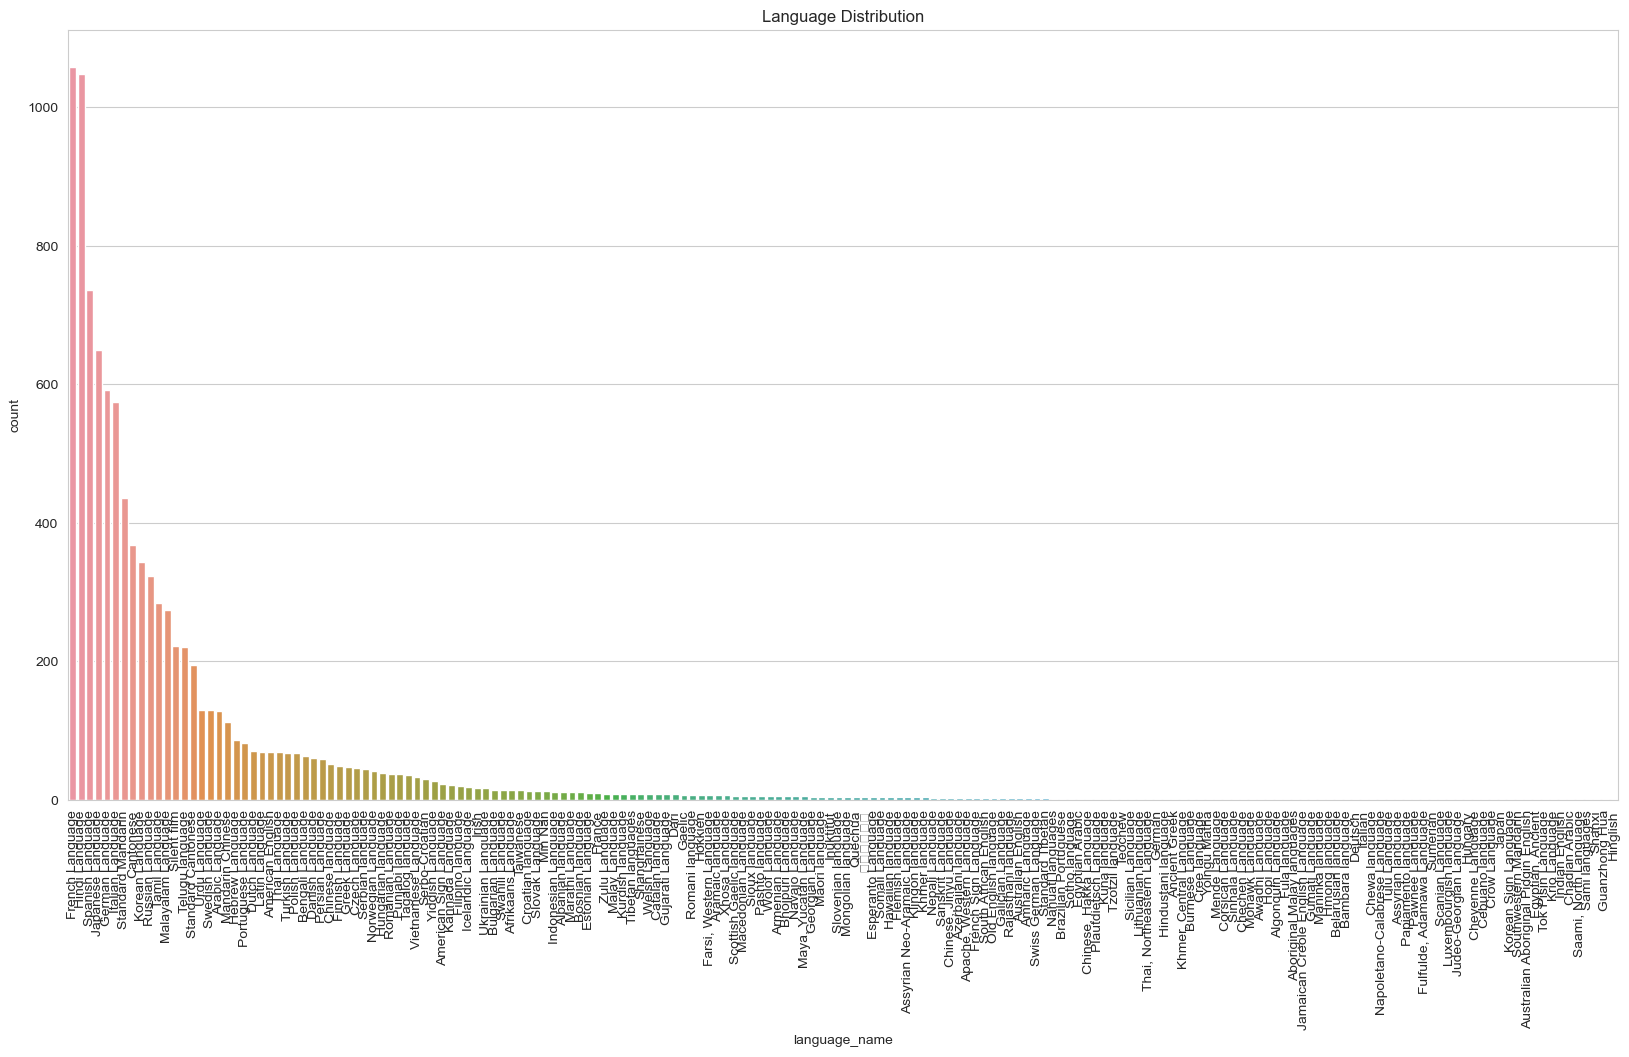

In [32]:
#plot a histogram of language distribution without "English Language"
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.title('Language Distribution')
sns.countplot(x='language_name', 
              data=languages_ratings_df[languages_ratings_df['language_name']!='English Language'], 
              order=languages_ratings_df[languages_ratings_df['language_name']!='English Language']['language_name'].value_counts().index)
plt.show()

Text(0.5, 1.0, 'Rating means with Error Bars for Most Occurring Languages in films')

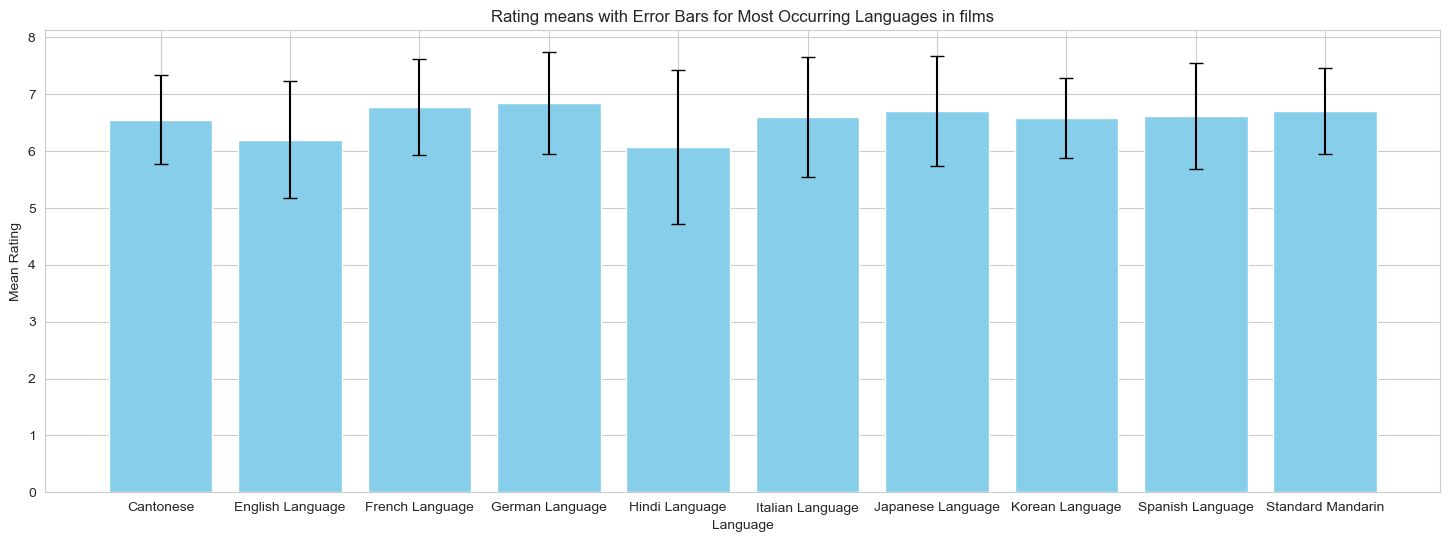

In [33]:
# Group by 'name' and calculate mean and standard deviation
grouped_df = languages_ratings_df.groupby('language_name')['averageRating'].agg(['mean', 'std', 'count'])

# Find the most occurring names
top_names = grouped_df['count'].nlargest(10).index

# Filter the DataFrame for the top names
filtered_df = languages_ratings_df[languages_ratings_df['language_name'].isin(top_names)]

# Group by 'name' again for plotting
plot_data = filtered_df.groupby('language_name')['averageRating']

# Calculate mean and standard deviation for error bars
mean_values = plot_data.mean()
std_values = plot_data.std()

# Plotting
plt.figure(figsize=(18, 6))
plt.bar(mean_values.index, mean_values, yerr=std_values, capsize=5, color='skyblue')
plt.xlabel('Language')
plt.ylabel('Mean Rating')
plt.title('Rating means with Error Bars for Most Occurring Languages in films')

In [34]:
def mann_whitney_u_test(language_to_test, df, elim_English=False):
    if elim_English:
        df = df[languages_ratings_df['language_name'] != 'English Language'].copy()
        if language_to_test == 'English Language':
            print("English films have been removed, so no test can be performed")
            return
    # Split the data into two groups: a and all others
    group_a = df[df['language_name'] == language_to_test]['averageRating']
    group_others = df[df['language_name'] != language_to_test]['averageRating']
    print("preforming Mann-Whitney U test with language {} and all others".format(language_to_test))
    if elim_English:
        print("not counting English films")
    # Perform the Mann-Whitney U test
    statistic, p_value = mannwhitneyu(group_a, group_others)
    print('Mann-Whitney U statistic:', statistic)
    print('Mann-Whitney p-value:', p_value)

Preforming Mann-Whitney U tests showed that if we account leave the english language in the pool of 'other' samples, runniing a Mann-Whitney U test yields a verry small p-value. Removing english shows that some languages tend to get a rather significant p-value, signifying that there may after all be a general tendancy to grade, not specific to each language.

In [35]:
languages_to_test =  ['English Language', 
                      'French Language', 
                      'German Language', 
                      'Italian Language', 
                      'Spanish Language', 
                      'Japanese Language', 
                      'German Language', 
                      'Standard Mandarin', 
                      'Korean Language', 
                      'Russian Language']

for language_to_tesst in languages_to_test:
    mann_whitney_u_test(language_to_tesst, languages_ratings_df)
for language_to_tesst in languages_to_test:
    mann_whitney_u_test(language_to_tesst, languages_ratings_df, elim_English=True)

preforming Mann-Whitney U test with language English Language and all others
Mann-Whitney U statistic: 51518659.5
Mann-Whitney p-value: 4.491175673363093e-293
preforming Mann-Whitney U test with language French Language and all others
Mann-Whitney U statistic: 15298831.5
Mann-Whitney p-value: 2.3837219635413183e-40
preforming Mann-Whitney U test with language German Language and all others
Mann-Whitney U statistic: 9000650.5
Mann-Whitney p-value: 1.5840030699858995e-31
preforming Mann-Whitney U test with language Italian Language and all others
Mann-Whitney U statistic: 7785192.0
Mann-Whitney p-value: 1.0181708786461179e-08
preforming Mann-Whitney U test with language Spanish Language and all others
Mann-Whitney U statistic: 9868477.0
Mann-Whitney p-value: 4.425797399256957e-10
preforming Mann-Whitney U test with language Japanese Language and all others
Mann-Whitney U statistic: 9248838.0
Mann-Whitney p-value: 1.7120564668957236e-18
preforming Mann-Whitney U test with language German 

In [36]:
reduced_languages_ratings_df = languages_ratings_df.head(2000)
#save to csv
reduced_languages_ratings_df.to_csv('data/RESULTS/erase_this_language.csv', index=False)

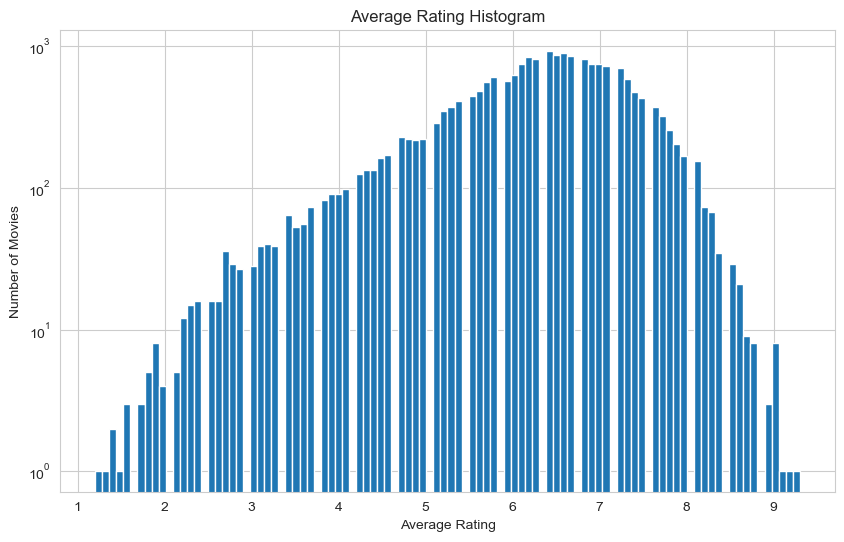

In [37]:
#plot box office revenue with a log scale
plt.figure(figsize=(10, 6))
plt.hist(movies_metadata_ratings_df['averageRating'], bins=100, log=True)
plt.xlabel('Average Rating')
plt.ylabel('Number of Movies')
plt.title('Average Rating Histogram')
plt.show()

In [38]:
# Calculate yearly stats across movies 
stats_by_year_df = movies_metadata_ratings_df.groupby(movies_metadata_ratings_df['movie_release_year']).apply(lambda x: pd.Series({
        'average_worldwide_rating': x['averageRating'].mean(),
        'std_dev_worldwide_rating': x['averageRating'].std()
    }))

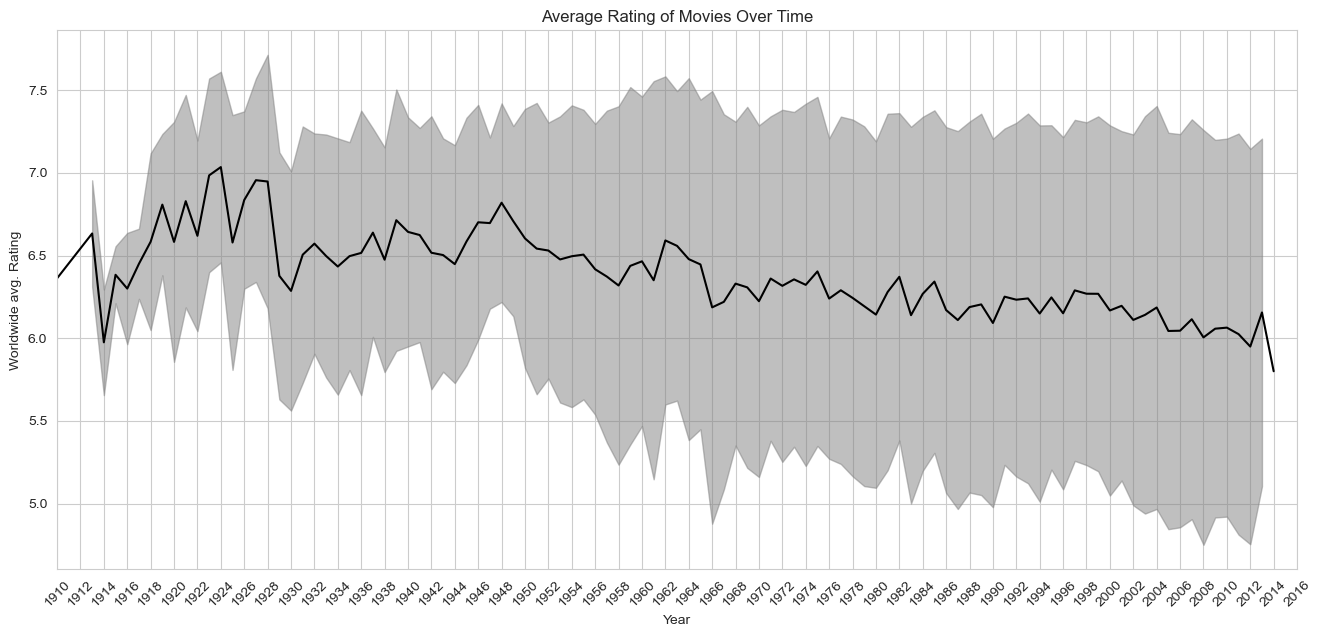

In [39]:
plt.figure(figsize=(16, 7))
plt.fill_between(stats_by_year_df.index, stats_by_year_df.average_worldwide_rating - stats_by_year_df.std_dev_worldwide_rating,
                 stats_by_year_df.average_worldwide_rating + stats_by_year_df.std_dev_worldwide_rating, alpha = 0.5, color = 'gray')

plt.plot(stats_by_year_df.average_worldwide_rating, color = 'black')
plt.xlabel('Year')
plt.xlim(1910, 2016)
plt.xticks(range(1910, 2016 + 1, 2))
plt.xticks(rotation=45)
plt.ylabel('Worldwide avg. Rating')
plt.title('Average Rating of Movies Over Time')
plt.show()

From this plot, we can conclude that ratings are almost in a decreasing trend, so if your movie wasn't released in the early 90's it is unlikely that you can hack the system. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


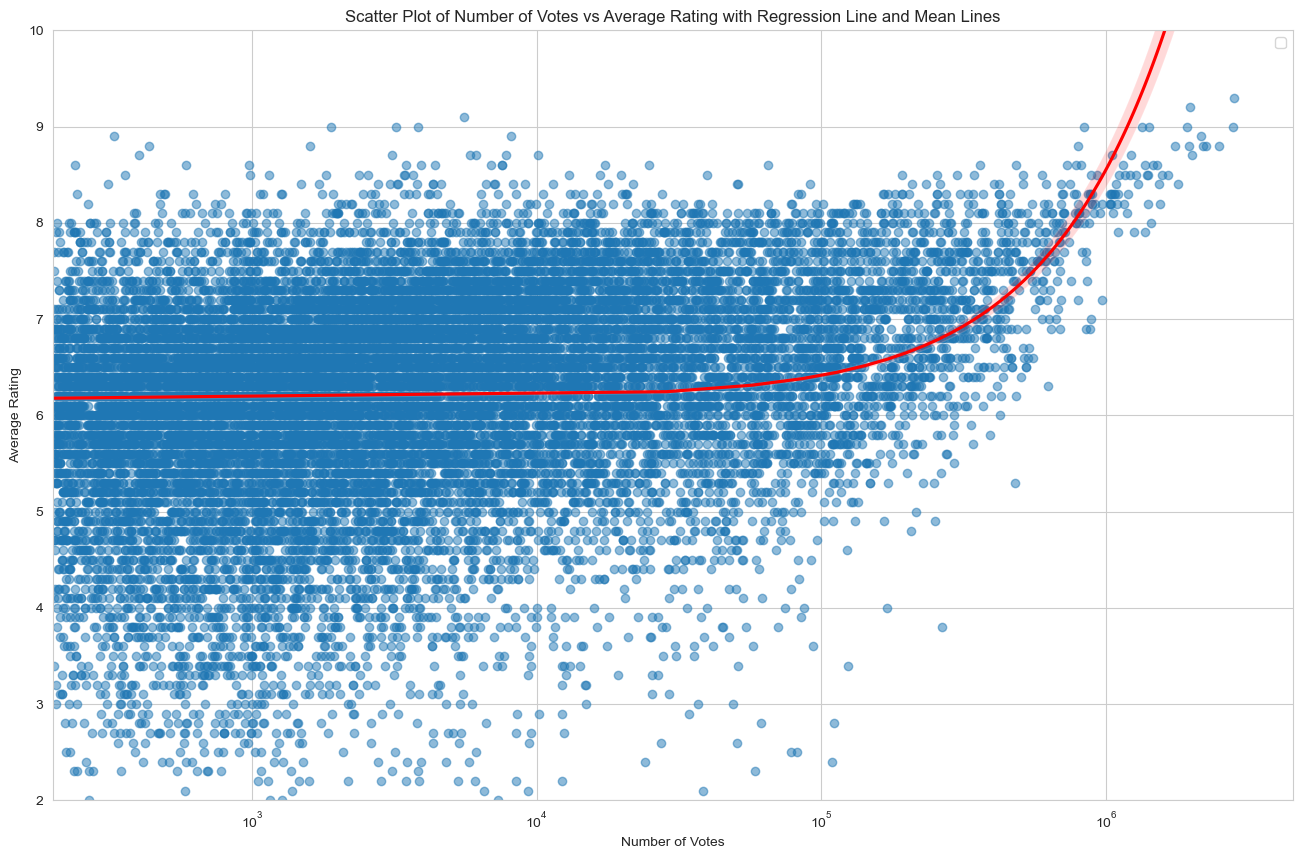

Pearson Correlation Coefficient: 0.24


In [40]:
# Assuming 'movie_metadata_ratings' is your DataFrame
# Replace this with your actual data
# Example:
# movie_metadata_ratings = pd.read_csv('your_data.csv')

# Filter relevant columns
selected_columns = ['numVotes', 'averageRating']
votes_rating_data_df = movies_metadata_ratings_df[selected_columns]

# # Drop rows with missing values (if any)
# votes_rating_data_df = votes_rating_data_df.dropna()

# Scatter plot with blue points and red regression line
plt.figure(figsize=(16, 10))
sns.regplot(data=votes_rating_data_df, x='numVotes', y='averageRating', scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})

# Calculate moving average for each vote number
window_size = 100  # You can adjust the window size according to your preference
moving_avg_by_vote_number = votes_rating_data_df.groupby('numVotes')['averageRating'].rolling(window=window_size).mean().reset_index(level=0, drop=True)

plt.title('Scatter Plot of Number of Votes vs Average Rating with Regression Line and Mean Lines')
plt.xlabel('Number of Votes')
plt.xscale('log')
plt.xlim(200)
plt.ylim(2, 10)
plt.ylabel('Average Rating')
plt.legend()  # Show the legend for mean lines
plt.show()

# Calculate Pearson correlation coefficient
correlation_coefficient = votes_rating_data_df['numVotes'].corr(votes_rating_data_df['averageRating'], method='pearson')
print(f"Pearson Correlation Coefficient: {correlation_coefficient:.2f}")


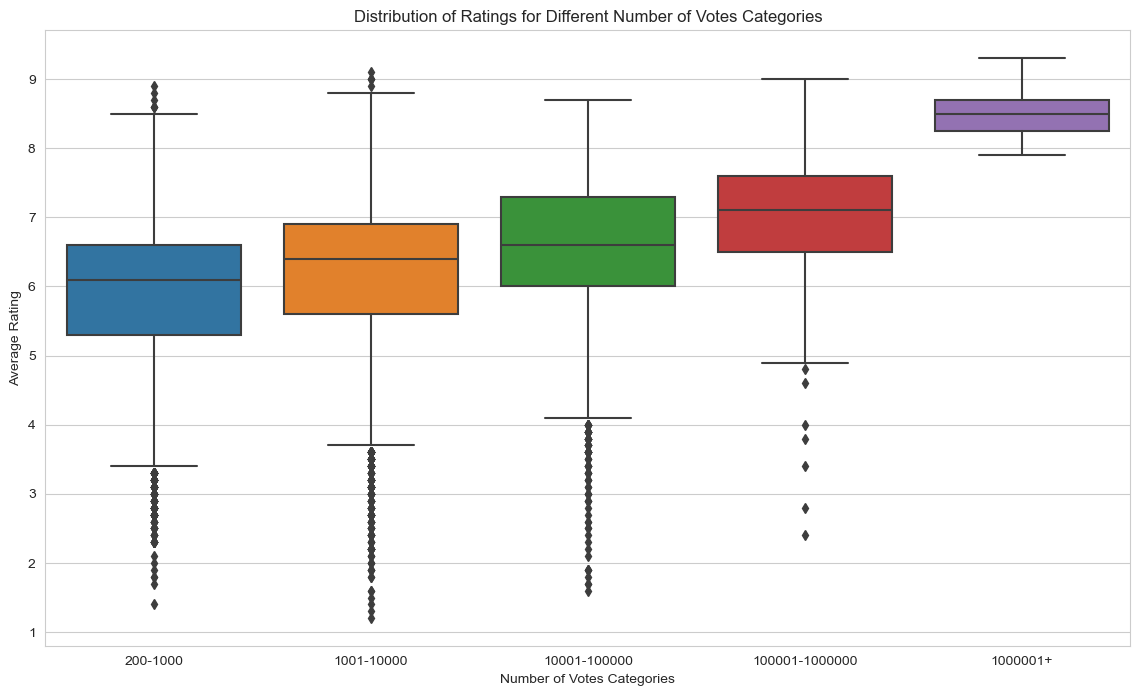

In [41]:
# Filter relevant columns
selected_columns = ['numVotes', 'averageRating']
votes_rating_data_df = movies_metadata_ratings_df[selected_columns]

# Drop rows with missing values (if any)
votes_rating_data_df = votes_rating_data_df.dropna()

# Create a new column for vote number categories (you can adjust the bin edges)
bins = [200, 1000, 10000, 100000, 1000000, float('inf')]
votes_rating_data_df['numVotesCategory'] = pd.cut(votes_rating_data_df['numVotes'], bins=bins, labels=['200-1000', '1001-10000', '10001-100000', '100001-1000000', '1000001+'])

# Create a box plot to compare the distribution of ratings for different vote number categories
plt.figure(figsize=(14, 8))
sns.boxplot(x='numVotesCategory', y='averageRating', data=votes_rating_data_df, order=['200-1000', '1001-10000', '10001-100000', '100001-1000000', '1000001+'])
plt.title('Distribution of Ratings for Different Number of Votes Categories')
plt.xlabel('Number of Votes Categories')
plt.ylabel('Average Rating')
plt.show()

In [42]:
#create a dataframe with only the movie countries
movie_countries_df = movie_metadata_df[['freebase_movie_id', 'movie_countries']]
movie_countries_df['movie_countries'] = movie_metadata_df['movie_countries'].apply(json.loads)
movie_countries_df['movie_countries'] = movie_countries_df['movie_countries'].apply(lambda x: x.values())
movie_countries_df = movie_countries_df.explode('movie_countries')
movie_countries_df.rename(columns={'movie_countries':'movie_countrie'}, inplace=True)
movie_countries_df.head()

,freebase_movie_id,movie_countrie
0,/m/03vyhn,United States of America
4,/m/01mrr1,Germany
13,/m/016ywb,United Kingdom
17,/m/0kcn7,United States of America
22,/m/05p45cv,United States of America


In [43]:
#create a dataframe with only the movie genres
movie_genres_df = movie_metadata_df[['freebase_movie_id', 'movie_genres']]
movie_genres_df['movie_genres'] = movie_metadata_df['movie_genres'].apply(json.loads)
movie_genres_df['movie_genres'] = movie_genres_df['movie_genres'].apply(lambda x: x.values())
movie_genres_df = movie_genres_df.explode('movie_genres')
movie_genres_df.rename(columns={'movie_genres':'movie_genre'}, inplace=True)
movie_genres_df.head(10)

,freebase_movie_id,movie_genre
0,/m/03vyhn,Thriller
0,/m/03vyhn,Science Fiction
0,/m/03vyhn,Horror
0,/m/03vyhn,Adventure
0,/m/03vyhn,Supernatural
0,/m/03vyhn,Action
0,/m/03vyhn,Space western
4,/m/01mrr1,Drama
13,/m/016ywb,Costume drama
13,/m/016ywb,War film


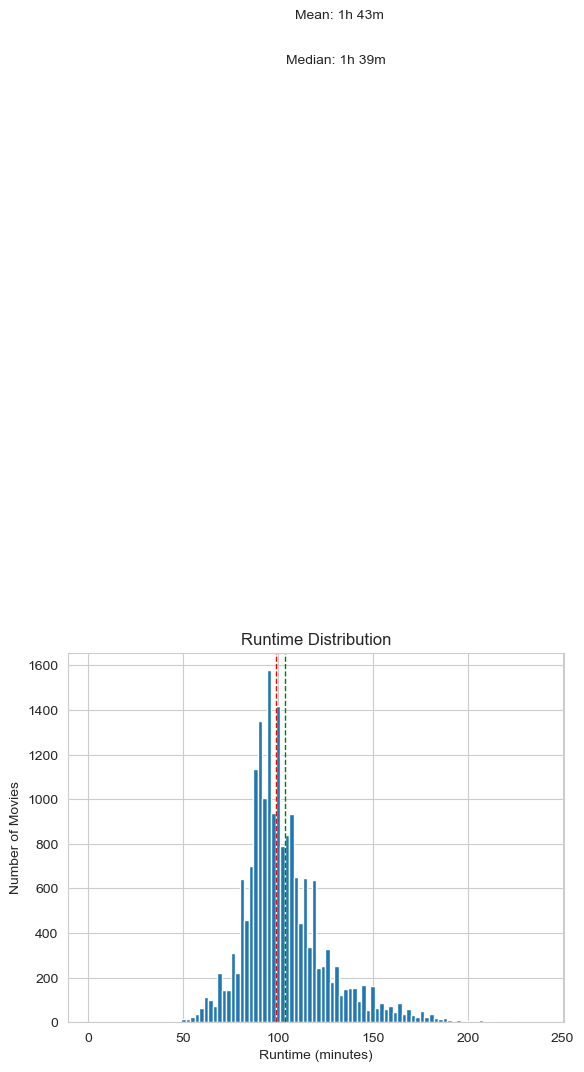

In [44]:
#plot runtime distribution with median and mean
plt.hist(movie_metadata_df[movie_metadata_df['movie_runtime'] < 240]['movie_runtime'], bins=100)
plt.axvline(movie_metadata_df['movie_runtime'].median(), color='red', linestyle='dashed', linewidth=1)
plt.text(movie_metadata_df['movie_runtime'].median() + 5, 4300, 'Median: ' + str(int(movie_metadata_df['movie_runtime'].median()/60)) + 'h ' + str(int(movie_metadata_df['movie_runtime'].median()%60)) + 'm')
plt.axvline(movie_metadata_df['movie_runtime'].mean(), color='green', linestyle='dashed', linewidth=1)
plt.text(movie_metadata_df['movie_runtime'].mean() + 5, 4500, 'Mean: ' + str(int(movie_metadata_df['movie_runtime'].mean()/60)) + 'h ' + str(int(movie_metadata_df['movie_runtime'].mean()%60)) + 'm')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Number of Movies')
plt.title('Runtime Distribution')
plt.show()

In [45]:
#5 shortest movies
movie_metadata_df.sort_values(by=['movie_runtime'], ascending=True).head(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year
54396,2322506,/m/073qxn,Fantastic Planet,1973-12-01,NaN,1.25,"{""/m/064_8sq"": ""French Language""}","{""/m/0f8l9c"": ""France"", ""/m/01mjq"": ""Czech Rep...","{""/m/02hmvc"": ""Short Film"", ""/m/06n90"": ""Scien...",1973.0
11762,33994214,/m/0hr6p_4,The King of Pigs,2011-10-08,NaN,1.50,{},"{""/m/06qd3"": ""South Korea""}","{""/m/02hmvc"": ""Short Film"", ""/m/0hcr"": ""Animat...",2011.0
56639,35025043,/m/0j63_8s,I Love You,2007,NaN,3.00,{},{},"{""/m/02hmvc"": ""Short Film""}",2007.0
45815,22816098,/m/0641r9w,Double Identity,2009,NaN,4.00,{},"{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/02wtdps"": ""Crime...",2009.0
78438,5467528,/m/0dn5gt,Our Relations,1936-10-30,NaN,7.00,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/0hj3mz5"": ""Com...",1936.0


In [46]:
def get_wikidata_id(freebase_id):
  sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
  query = f"""
  SELECT ?article ?label
  WHERE 
  {{
    ?article schema:about ?item;
        schema:isPartOf <https://en.wikipedia.org/> .
    ?item wdt:P646 "{freebase_id}";
          rdfs:label ?label.
    FILTER(LANG(?label) = "en") # Optional: Filter by English labels
  }}
  """
  sparql.setQuery(query)
  sparql.setReturnFormat(JSON)
  
  try:
      results = sparql.query().convert()
      if 'results' in results and 'bindings' in results['results'] and len(results['results']['bindings']) > 0:
          return results['results']['bindings'][0]['label']['value']
  except Exception as e:
      print(f"Error: {e}")
      time.sleep(20)
      return get_wikidata_id(freebase_id)
  
  return None

In [47]:
#extract the actor ethnicity into a Series from the character metadata removing duplicates
actor_ethnicity_df = character_metadata_df["actor_ethnicity"].drop_duplicates().dropna().reset_index(drop=True)

In [48]:
#create a dataframe from the results of the sparql query from every element in actor_ethnicity_series
# if data/RESULTS/ethnicities_name.csv exists, load it

ethnicities_name_filename = 'data/RESULTS/ethnicities_name.csv'

if os.path.exists(ethnicities_name_filename):
    ethnicities_name_df = pd.read_csv(ethnicities_name_filename)
else:
    ethnicity_queried_values = [get_wikidata_id(value) for value in actor_ethnicity_df]
    ethnicities_name_df = pd.DataFrame({'ethnicity_id': actor_ethnicity_df, 'ethnicity_name': ethnicity_queried_values})
    # save to csv
    ethnicities_name_df.to_csv(ethnicities_name_filename, index=False)
ethnicities_name_df.head(10)

,ethnicity_id,ethnicity_name
0,/m/044038p,NaN
1,/m/0x67,African Americans
2,/m/064b9n,Omaha people
3,/m/033tf_,Irish Americans
4,/m/0xnvg,Italian Americans
5,/m/041rx,Jewish people
6,/m/0dqqwy,Danish Americans
7,/m/048z7l,American Jews
8,/m/07bch9,Scottish American
9,/m/04dbw3,Cuban American


In [49]:
# merge character_metadata_df with df on actor_ethnicity and ethnicity_name
character_metadata_df = pd.merge(character_metadata_df, ethnicities_name_df, 
                                 left_on='actor_ethnicity', 
                                 right_on='ethnicity_id', 
                                 how='left')

character_metadata_df.drop(columns=["ethnicity_id"], inplace=True)
character_metadata_df.rename(columns={'actor_ethnicity': 'actor_ethnicity_id', 'ethnicity_name':'actor_ethnicity', }, inplace=True)
character_metadata_df.head(10)

,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,movie_release_year,actor_ethnicity
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001.0,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001.0,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001.0,African Americans
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001.0,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001.0,NaN
5,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft,2001.0,African Americans
6,975900,/m/03vyhn,2001-08-24,Whitlock,1945-08-02,F,1.753,NaN,Joanna Cassidy,56.0,/m/02vd6kw,/m/0bgchmx,/m/06lj1m,2001.0,NaN
7,975900,/m/03vyhn,2001-08-24,Big Daddy Mars,NaN,M,NaN,NaN,Richard Cetrone,NaN,/m/0bgchsy,/m/0bgcht0,/m/0bgcht7,2001.0,NaN
8,975900,/m/03vyhn,2001-08-24,Michael Descanso,1971-03-20,M,1.892,NaN,Liam Waite,30.0,/m/03jqhb0,/m/0bgchs4,/m/0ks8b0,2001.0,NaN
9,975900,/m/03vyhn,2001-08-24,Uno,NaN,M,NaN,NaN,Duane Davis,NaN,/m/0bgchtj,/m/0bgchtm,/m/03nrwdy,2001.0,NaN


In [50]:
#characters that have been played by multiple actors
character_metadata_df[character_metadata_df['character_name'].duplicated(keep=False)].sort_values(by=['character_name'])

,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,movie_release_year,actor_ethnicity
72346,747689,/m/037_84,1979-03-14,'3-5-0-0' Soloist,1950-06-05,M,NaN,NaN,Ronnie Dyson,28.0,/m/0gy_y5r,/m/0h5rdn3,/m/01p27qd,1979.0,NaN
72331,747689,/m/037_84,1979-03-14,'3-5-0-0' Soloist,1945-10-29,F,NaN,/m/0x67,Melba Moore,33.0,/m/0cg6hqj,/m/0h5rdnt,/m/08rgr4,1979.0,African Americans
15754,673694,/m/031tc2,1988-08-10,'Jose' Chavez y Chavez,1962-02-17,M,1.85,/m/03295l,Lou Diamond Phillips,26.0,/m/02vcg9t,/m/0h2k5dk,/m/031zkw,1988.0,Filipino Americans
11936,675213,/m/031zk3,1990-08-01,'Jose' Chavez y Chavez,1962-02-17,M,1.85,/m/03295l,Lou Diamond Phillips,28.0,/m/02vc4lz,/m/0h2k5dk,/m/031zkw,1990.0,Filipino Americans
74539,28370864,/m/0crfcdl,2011-08-12,'Juicy' Judy Gonzalez,1977-03-26,F,1.73,NaN,Bianca Kajlich,34.0,/m/0gvd8fd,/m/0cgm75g,/m/0dlbpj,2011.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192520,22330502,/m/05sync6,1931-01-31,NaN,1889-07-15,F,NaN,NaN,Marjorie Rambeau,NaN,/m/05tg4vt,NaN,/m/079q2l,1931.0,NaN
192521,24997872,/m/09g6klx,2010-05-07,NaN,1972-09-09,M,NaN,/m/01rv7x,Riyaz Khan,37.0,/m/0h888_7,NaN,/m/04645zm,2010.0,Tamil
192525,24997872,/m/09g6klx,2010-05-07,NaN,1944-08-01,M,NaN,/m/01rv7x,Delhi Ganesh,65.0,/m/0h6krrl,NaN,/m/04cw5sb,2010.0,Tamil
192526,24997872,/m/09g6klx,2010-05-07,NaN,1948-05-22,M,NaN,/m/04mvp8,Nedumudi Venu,61.0,/m/0h7yl4y,NaN,/m/02hkw6,2010.0,Malayali


## 3. Movie runtime and average rating

In [51]:
movie_runtime_rating_df = movies_metadata_ratings_df[['movie_runtime','averageRating']]
filtered_movie_runtime_rating_df = movie_runtime_rating_df[movie_runtime_rating_df['movie_runtime'] < 400]
movie_runtime_rating_df.head()

,movie_runtime,averageRating
0,98.0,4.9
3,106.0,5.9
8,137.0,7.5
9,139.0,7.8
13,82.0,6.1


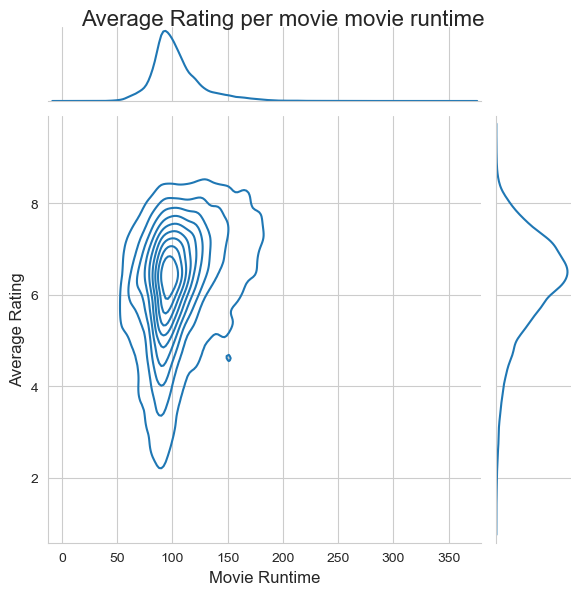

In [52]:
g = sns.jointplot(x=filtered_movie_runtime_rating_df['movie_runtime'], 
                  y=filtered_movie_runtime_rating_df['averageRating'], 
                  kind='kde', 
                  height=6)

# Set labels and title
g.set_axis_labels('Movie Runtime', 'Average Rating', fontsize=12)
g.fig.suptitle('Average Rating per movie movie runtime ', fontsize=16)
g.fig.subplots_adjust(top=0.95)

In [53]:
correlation_coefficient, p_value = pearsonr(filtered_movie_runtime_rating_df['movie_runtime'], 
                                            filtered_movie_runtime_rating_df['averageRating'])
print(f"Correlation Coefficient: {correlation_coefficient}")
print(f"P-Value: {p_value}")

Correlation Coefficient: 0.2566673074667025
P-Value: 7.922684158864968e-287


## Interpretation

The obtained p-value indicate that the correlation coeficient observed is statisticlly significant, meaning that is almost impossible to observe such result by random chance. The correlation coefficient 0.227 indicate a small positif linear relationship meaning that when the movie runtime increases, there is a tendency for the average rating to also increase slightly. However, our correlation coefficient is relatively small, thus it is indicating that movie runtime alone does not explain a large portion of the variability in average ratings.

The density of contours around the center suggests that a majority of movies have a runtime between approximately 90 to 150 minutes and these movies tend to have a wide range of ratings. However, there is a noticeable concentration of higher ratings (between 6 and 8 on average) for movies that fall within this runtime range. The peak of the distribution for average ratings also seems to correspond to a movie runtime of around 100 to 120 minutes, indicating that this duration is optimal for achieving higher ratings.

There are fewer movies with short or very long runtimes.The contour lines spread wider at the extremes, particularly for the longer runtime end, which suggests more variability in the ratings of movies with longer runtimes. This could indicate that while longer movies have the potential to achieve high ratings, it is less consistent.

Movie runtime is an important parameter because it needs to be sufficient enough to develop the plot and characters correctly, but not so long that it risks losing the audience's attention. The sweet spot indicated by the graph suggests that viewers may prefer movies that are long enough to be engaging and complete but short enough to maintain attention and interest throughout.

## 4. Large Revenue Corelation With The IMDB Ratings

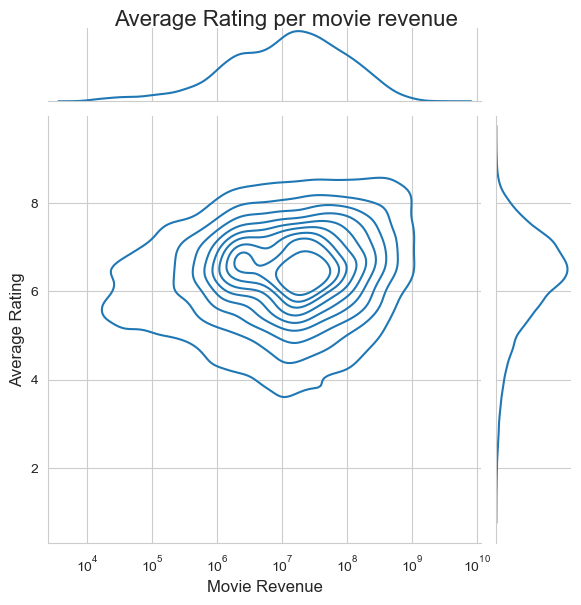

In [54]:
# plot the average rating per movie revenue
g = sns.jointplot(x=movies_metadata_ratings_df['movie_box_office_revenue'],
              y=movies_metadata_ratings_df['averageRating'],
              kind='kde',
              height=6,
              log_scale=(True, False))

# Set labels and title
g.set_axis_labels('Movie Revenue', 'Average Rating', fontsize=12)
g.fig.suptitle('Average Rating per movie revenue', fontsize=16)
g.fig.subplots_adjust(top=0.95)

## 5. Linking events to movies 

in this section we are going to try to link movie summaries with historical events, to do that we chose to use the BERT-Large model from hugging face.
- first we tokenize the event description, then we compute the embeddings for this description
- then we tokenize the summary and we compute the embeddings for this summary

In [55]:
import torch
from transformers import BertTokenizer, BertModel

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-Large-cased')
model = BertModel.from_pretrained('bert-large-cased')

# Function to tokenize and encode text
def encode(text, max_length=512):
    # Subtract 2 for [CLS] and [SEP] tokens
    if len(text) == 0:
        print("Empty text")  # Debugging
    
    max_length -= 2
    tokens = tokenizer.tokenize(text)
    if len(tokens) == 0:
        print("Empty tokens")  # Debugging
    chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]
    if not chunks:  # Check if chunks are empty
        print(f"No chunks for text: {text}")  # Debugging

    # Process each chunk
    chunk_embeddings = []
    for chunk in chunks:
        # Add special tokens
        chunk = ['[CLS]'] + chunk + ['[SEP]']
        input_ids = tokenizer.convert_tokens_to_ids(chunk)
        input_tensor = torch.tensor([input_ids]).to('cuda' if torch.cuda.is_available() else 'cpu')
        with torch.no_grad():
            last_hidden_states = model(input_tensor)[0]  # Get the embeddings
        chunk_embeddings.append(last_hidden_states[0].mean(dim=0))

    # Aggregate the embeddings from each chunk (mean pooling here)
    embeddings = torch.mean(torch.stack(chunk_embeddings), dim=0)
    return embeddings

c:\Users\yanis\anaconda3\envs\ada\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [56]:
# the embedding is made in another notebook because it took 20 h to run

Create event description embeddings

In [57]:
events_embeddings_filename = 'data/EMBEDDINGS/events_embeddings.csv'

if not os.path.exists(events_embeddings_filename):
    # Tokenize, encode, and get embeddings
    events_df['Embeddings'] = events_df['Event Description'].apply(lambda x: encode(x).tolist() if pd.notnull(x) else None)
    
    #save the embeddings of events as a csv file
    events_df.to_csv('data/RESULTS/events_embeddings.csv', index=False)


Create movie summary plot emberddings

In [58]:
plot_summaries_embeddings_filename = 'data/EMBEDDINGS/plot_summaries_embeddings.csv'

if not os.path.exists(plot_summaries_embeddings_filename):
    # add a column to the plot_summaries_df with embedding of the summary
    plot_summaries_df['Embeddings'] = plot_summaries_df['plot_summary'].apply(lambda x: encode(x).tolist() if pd.notnull(x) else None)

    #save the embeddings of summaries as a csv file
    plot_summaries_df.to_csv('data/plot_summaries_embeddings.csv', index=False)

Load the event embeddings and summaries embeddings

In [59]:
# Function to convert string representation back to list
def string_to_tensor(string):
    try:
        return torch.tensor(ast.literal_eval(string))
    except ValueError:
        return None

events_embedded_df = pd.read_csv(events_embeddings_filename)
# Convert string representation back to tensor
events_embedded_df['Embeddings'] = events_embedded_df['Embeddings'].apply(string_to_tensor)

summaries_embedded_df = pd.read_csv(plot_summaries_embeddings_filename)
# Convert string representation back to tensor
summaries_embedded_df['Embeddings'] = summaries_embedded_df['Embeddings'].apply(string_to_tensor)

Link every movie summary with an event

In [60]:
#create a merged dataset with the movie metadata and the summaries(with the embeddings)
merged_movie_df = pd.merge(summaries_embedded_df, 
                           movies_metadata_ratings_df, 
                           on='wiki_movie_id', 
                           how='inner')

# Function to calculate cosine similarity manually
def calculate_similarity(a, b):
    similarity = 1 - cosine(a, b)
    return similarity

In [61]:
def match_event_from_summary_embeddings(movie_embedding, movie_release_year):
    # Filter events that happened before the movie was released (at least 2 years since it takes time to make a movie)
    filtered_events = events_embedded_df[events_embedded_df['Year'] < (int(movie_release_year)-2)]
    # Calculate the similarity between the movie and all events
    similarities = filtered_events['Embeddings'].apply(lambda x: calculate_similarity(movie_embedding, x))
    # Get the index of the most similar event
    index = similarities.idxmax()
    # Get the similarity score of the most similar event
    similarity = similarities[index]
    # Get the name of the most similar event
    matched_event_name = filtered_events.loc[index]['Event Name']
    return similarity, matched_event_name

In [62]:
linked_movies_and_events_filename = 'data/RESULTS/linked_movies_and_events_df.csv'

if not os.path.exists(linked_movies_and_events_filename):
    # Initialize an empty list to store movie data
    linked_movies_events = []

    # Loop through each movie
    for index, movie in merged_movie_df.iterrows():
        # Your existing logic to get movie_embedding, movie_release_year, similarity, and matched_event
        movie_embedding = movie['Embeddings']
        movie_release_year = movie['movie_release_year']
        similarity, matched_event = match_event_from_summary_embeddings(movie_embedding, movie_release_year)
        event_description = events_df[events_df['Event Name'] == matched_event]['Event Description'].values[0]

        # Create a dictionary for the current movie
        movie_data = {
            'wiki_movie_id': movie['wiki_movie_id'],
            'movie_name': movie['movie_name'],
            'plot_summary': movie['plot_summary'],
            'matched_event': matched_event,
            'event description': event_description,
            'similarity_score': similarity,
            'rating': movie['averageRating']
        }

        # Append the dictionary to the list
        linked_movies_events.append(movie_data)

    # Create a DataFrame from the list of dictionaries
    linked_movies_and_events_df = pd.DataFrame(linked_movies_events)

    #save the dataframe to csv
    linked_movies_and_events_df.to_csv(linked_movies_and_events_filename, index=False)

- lastly we compare the embedding of the movie summary with all the events embeddings and we pick the event that matches the most.

In [63]:
# the comparison is made in another notebook

after running the Bert model to get the embeddings and assigning each movie to an event we read the resulting file 

In [64]:
# read the linked_movies_and_events_df 
linked_movies_and_events_df = pd.read_csv(linked_movies_and_events_filename)

linked_movies_and_events_df.sort_values(by=['similarity_score'], ascending=False, inplace=True)

#save the dataframe to csv
linked_movies_and_events_df.to_csv(linked_movies_and_events_filename, index=False)

movies_related_to_events_df = linked_movies_and_events_df[linked_movies_and_events_df['similarity_score'] > 0.77]

movies_unrelated_to_events_df = linked_movies_and_events_df[linked_movies_and_events_df['similarity_score'] < 0.7]

we calculate the 

In [65]:
avearge_rating_all = linked_movies_and_events_df['rating'].mean()
avearge_rating_related = movies_related_to_events_df['rating'].mean()
avearge_rating_unrelated = movies_unrelated_to_events_df['rating'].mean()
print('Average rating of movies related to events: ', avearge_rating_related)
print('Average rating of movies unrelated to events: ', avearge_rating_unrelated)
print('Average rating of movies  ', avearge_rating_all)

# perform the t-test
ttest_ind(movies_related_to_events_df['rating'], movies_unrelated_to_events_df['rating'])
# print the p-value
print('p-value: ', ttest_ind(movies_related_to_events_df['rating'], movies_unrelated_to_events_df['rating'])[1])

Average rating of movies related to events:  6.31342229199372
Average rating of movies unrelated to events:  6.149867319861197
Average rating of movies   6.251343062082611
p-value:  2.0778564702913703e-06


We can see that the p-value is less than 0.05 so we can reject the null hyposesis.
- we can interpret that the fact that a movie is related to a historical event improves the IMDb rating.

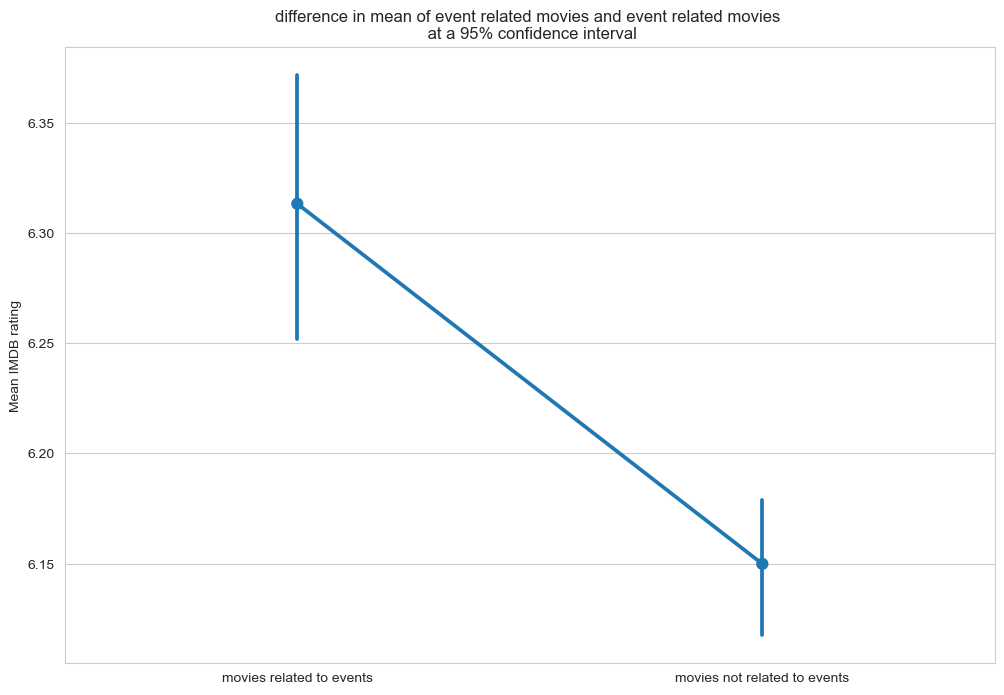

In [66]:
related_unrelated_movies = pd.DataFrame({'movies related to events': movies_related_to_events_df['rating'] , \
                                         'movies not related to events': movies_unrelated_to_events_df['rating']})

plt.figure(figsize=(12, 8))
# plot the mean salary for each throwing hand
sns.pointplot(data=related_unrelated_movies, errorbar=("ci", 95))
plt.title("difference in mean of event related movies and event related movies \n at a 95% confidence interval")
plt.ylabel("Mean IMDB rating")
plt.grid(axis='y', linestyle='-')
plt.show()

## 6. Evaluate the effect of Oscars nominations and wins on Movie sucess

In [67]:
# keep freebase_character_id, actor_name, movie_release_year columns only
character_award_year_df = character_metadata_award_df[['freebase_character_id', 'actor_name', 'movie_release_year']]
character_award_year_df.head()

,freebase_character_id,actor_name,movie_release_year
271,NaN,Louise Dresser,1928.0
1177,NaN,Richard Barthelmess,1928.0
451,/m/0cfyb52,Gloria Swanson,1928.0
705,NaN,Emil Jannings,1928.0
789,NaN,George Bancroft,1929.0


In [68]:
# keep wiki_movie_id, actor_name, movie_release_year columns only
character_subset_df = character_metadata_df[['wiki_movie_id', 'freebase_character_id', 'actor_name', 'movie_release_year']]
#drop na in movie_release_year
character_subset_df = character_subset_df[character_subset_df['movie_release_year'].notna()]
character_subset_df

,wiki_movie_id,freebase_character_id,actor_name,movie_release_year
0,975900,/m/0bgcj3x,Wanda De Jesus,2001.0
1,975900,/m/0bgchn4,Natasha Henstridge,2001.0
2,975900,/m/0bgchn_,Ice Cube,2001.0
3,975900,/m/0bgchnq,Jason Statham,2001.0
4,975900,/m/0bgchp9,Clea DuVall,2001.0
...,...,...,...,...
192535,30553937,/m/0jxtp_8,Steve Monarque,1998.0
192536,30553937,/m/0jxtpzq,Kevin Richardson,1998.0
192537,30553937,/m/0jxtsvz,Leda Mulholland,1998.0
192538,30553937,/m/0jxtsx8,Randy Harris,1998.0


In [69]:
character_subset_award_year_df = pd.merge(character_subset_df, 
                                          character_award_year_df, 
                                          on=['freebase_character_id', 'actor_name'], 
                                          how='left', 
                                          suffixes=('', '_nominated'))

# remove rows there movie_release_year_nominated is na
character_subset_award_year_df = character_subset_award_year_df[character_subset_award_year_df['movie_release_year_nominated'].notna()]
# remove rows where movie_release_year smaller or equal to movie_year_nominated
character_subset_award_year_df = character_subset_award_year_df[character_subset_award_year_df['movie_release_year'] > character_subset_award_year_df['movie_release_year_nominated']]
# drop duplicates in the wiki_movie_id column
character_subset_award_year_df.drop_duplicates(subset=['wiki_movie_id'], inplace=True)
character_subset_award_year_df.head()

,wiki_movie_id,freebase_character_id,actor_name,movie_release_year,movie_release_year_nominated
132,4340003,NaN,James Gleason,1947.0,1941.0
144,1369204,NaN,Paul Muni,1939.0,1929.0
196,21209475,NaN,Leslie Howard,1934.0,1933.0
273,24863901,NaN,Diahann Carroll,2010.0,1974.0
412,1940449,NaN,Mako,1993.0,1966.0


In [70]:
# add a column in the movie_metadata_df for named awarded_character
movie_metadata_rating_df['nominated_character'] = movie_metadata_rating_df['wiki_movie_id'].isin(character_subset_award_year_df['wiki_movie_id'])

# make the awarded_character true if the movie is present in the df
movie_metadata_rating_df['nominated_character'] = movie_metadata_rating_df['nominated_character'].apply(lambda x: True if x else False)

movie_metadata_rating_df.head()

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,tconst,averageRating,numVotes,titleType,nominated_character
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,tt0228333,4.9,56920,movie,False
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988.0,tt0094806,5.6,40,movie,False
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983.0,tt0083949,5.9,623,movie,False
5,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938.0,tt0029852,6.8,2268,movie,False
6,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01g6gs"": ""Black-an...",1930.0,tt0021335,5.4,300,movie,False


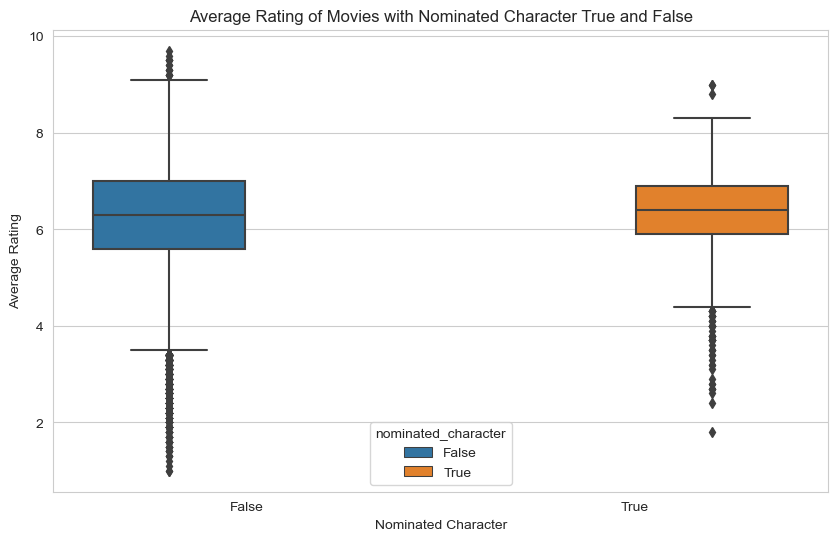

In [71]:
# plot the average rating of the movies with nominated_character true and false
plt.figure(figsize=(10, 6))
sns.boxplot(x='nominated_character', y='averageRating', data=movie_metadata_rating_df, hue='nominated_character')
plt.xlabel('Nominated Character')
plt.ylabel('Average Rating')
plt.title('Average Rating of Movies with Nominated Character True and False')
plt.show()

In [72]:
# drop characters that did not win an oscar
character_metadata_winner_df = character_metadata_award_df[character_metadata_award_df['winner'] == True]

# keep freebase_character_id, actor_name, movie_release_year columns only
character_winner_year_df = character_metadata_winner_df[['freebase_character_id', 'actor_name', 'movie_release_year']]
character_winner_year_df.head()

,freebase_character_id,actor_name,movie_release_year
705,NaN,Emil Jannings,1928.0
146,/m/0by5j17,Mary Pickford,1929.0
30,NaN,Warner Baxter,1929.0
349,NaN,Norma Shearer,1930.0
341,/m/0b_jnzp,George Arliss,1929.0


In [73]:
character_subset_winner_df = pd.merge(character_subset_df, 
                                      character_metadata_winner_df, 
                                      on=['freebase_character_id', 'actor_name'], 
                                      how='left', 
                                      suffixes=('', '_awarded'))

# remove rows there movie_release_year_y is na
character_subset_winner_df = character_subset_winner_df[character_subset_winner_df['movie_release_year_awarded'].notna()]
# remove rows where movie_release_year_x smaller or equal to movie_release_year_y
character_subset_winner_df = character_subset_winner_df[character_subset_winner_df['movie_release_year'] > character_subset_winner_df['movie_release_year_awarded']]
# drop duplicates in the wiki_movie_id column
character_subset_winner_df.drop_duplicates(subset=['wiki_movie_id'], inplace=True)
character_subset_winner_df.head()

,wiki_movie_id,freebase_character_id,actor_name,movie_release_year,wiki_movie_id_awarded,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,...,movie_name,year_film,year_ceremony,ceremony,category,name,film,winner,nomination_count,win_count
144,1369204,NaN,Paul Muni,1939.0,61514.0,/m/0gnp3,1936,NaN,1895-09-22,M,...,The Story of Louis Pasteur,1936.0,1937.0,9.0,ACTOR,Paul Muni,The Story of Louis Pasteur,True,5.0,1.0
576,6512034,NaN,Lionel Barrymore,1941.0,144765.0,/m/012c5t,1931-06-20,NaN,1878-04-28,M,...,A Free Soul,1930.0,1931.0,4.0,ACTOR,Lionel Barrymore,A Free Soul,True,5.0,1.0
1211,8610844,NaN,Anne Baxter,1956.0,6000549.0,/m/0fj_jb,1946-11-19,NaN,1923-05-07,F,...,The Razor's Edge,1946.0,1947.0,19.0,ACTRESS IN A SUPPORTING ROLE,Anne Baxter,The Razor's Edge,True,5.0,1.0
1523,6839059,NaN,Maggie Smith,1984.0,22332882.0,/m/05sy5dr,1969,NaN,1934-12-28,F,...,The Prime of Miss Jean Brodie,1969.0,1970.0,42.0,ACTRESS,Maggie Smith,The Prime of Miss Jean Brodie,True,5.0,1.0
2398,12794862,NaN,Jane Wyman,1949.0,80533.0,/m/0kv00,1948,NaN,1917-01-05,F,...,Johnny Belinda,1948.0,1949.0,21.0,ACTRESS,Jane Wyman,Johnny Belinda,True,5.0,1.0


In [74]:
# add a column in the movie_metadata_df for named awarded_character
movie_metadata_rating_df['awarded_character'] = movie_metadata_rating_df['wiki_movie_id'].isin(character_subset_winner_df['wiki_movie_id'])

# make the awarded_character true if the movie is present in the df
movie_metadata_rating_df['awarded_character'] = movie_metadata_rating_df['awarded_character'].apply(lambda x: True if x else False)

movie_metadata_rating_df.head()

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,tconst,averageRating,numVotes,titleType,nominated_character,awarded_character
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,tt0228333,4.9,56920,movie,False,False
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988.0,tt0094806,5.6,40,movie,False,False
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983.0,tt0083949,5.9,623,movie,False,False
5,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938.0,tt0029852,6.8,2268,movie,False,False
6,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01g6gs"": ""Black-an...",1930.0,tt0021335,5.4,300,movie,False,False


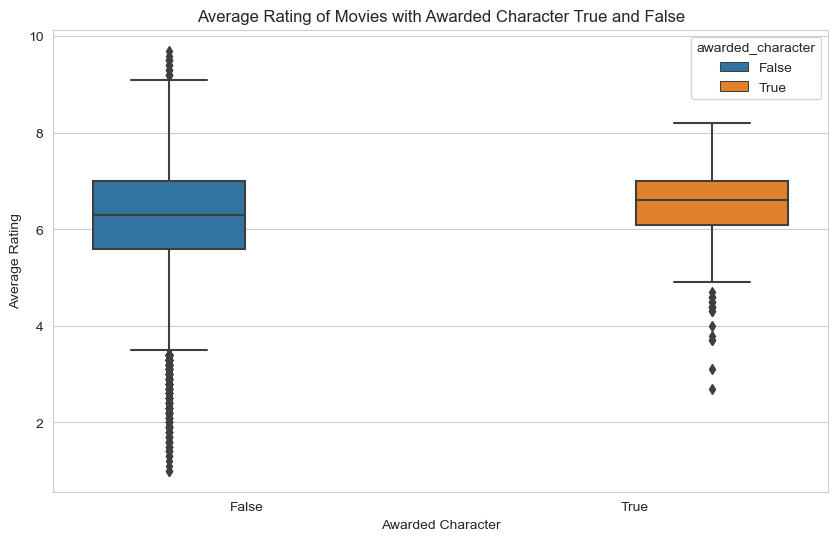

In [75]:
# plot the average rating of the movies with awarded_character true and false
plt.figure(figsize=(10, 6))
sns.boxplot(x='awarded_character', y='averageRating', data=movie_metadata_rating_df, hue='awarded_character')
plt.xlabel('Awarded Character')
plt.ylabel('Average Rating')
plt.title('Average Rating of Movies with Awarded Character True and False')
plt.show()

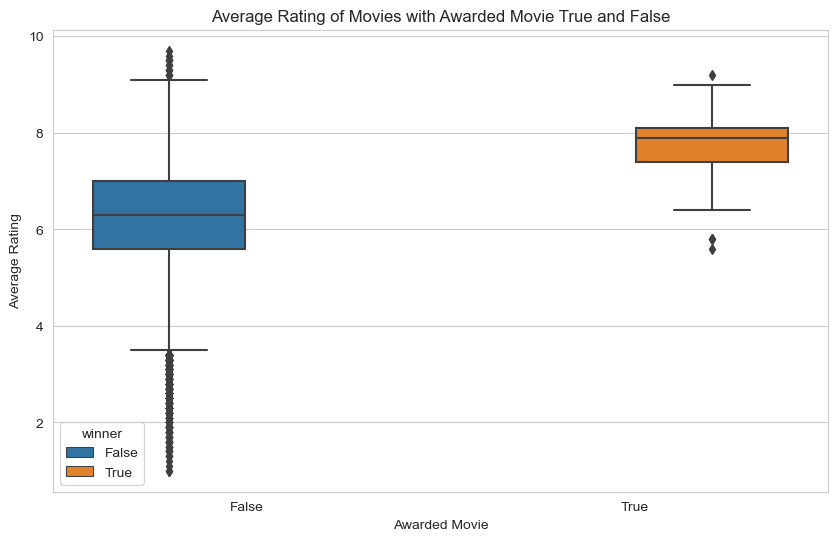

In [76]:
# plot the average rating of the movies with won oscar true and false
plt.figure(figsize=(10, 6))
sns.boxplot(x='winner', y='averageRating', data=movie_metadata_rating_award_df, hue='winner')
plt.xlabel('Awarded Movie')
plt.ylabel('Average Rating')
plt.title('Average Rating of Movies with Awarded Movie True and False')
plt.show()